In [43]:
import pandas as pd
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import ast
import pickle
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [44]:
INDEX_PATH = "inv_index.pkl"

In [45]:
# Take data from csv and construct a dataframe, sanity check for empty rows
df = pd.read_csv("openalex_papers4.csv").fillna('').reset_index(drop=True)

In [46]:
# Common stop symbols in the english lexicon
stop_words = set(stopwords.words("english"))

In [47]:
class BM25:
    def __init__(self, index, k1, b):
        """
            The following are numpy array/vectors
            frq: Frequency of word in document D,
            sd: size of document (in words),
            avgwdl: average documents length in corpus(/collection),
            k1: term frequency scaling,
            b: document length normalization,
            N: Total documents,
            n_qt: Number of documents containing query term
        """

        self.postings = index["postings"]
        self.doc_len  = index["doc_len"]
        self.N        = index["N"]
        self.avgdl    = index["avgdl"]
        self.k1 = k1
        self.b = b

    def Idf(self, n_qt):
        return np.log(1 + (self.N / n_qt))

    def Tf(self, tf, dl):
        return tf*(self.k1 + 1) / (
            tf + self.k1 * (1 - self.b + self.b * dl / self.avgdl)
        )


    def formula(self, query_terms):
        scores = defaultdict(float)

        for term in query_terms:
            postings = self.postings.get(term)
            if not postings:
                continue

            n_q = len(postings)
            idf = self.Idf(n_q)

            for doc_id, tf in postings.items():
                dl = self.doc_len[doc_id]
                scores[doc_id] += idf * self.Tf(tf, dl)

        return dict(scores)

In [48]:
def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [
        t for t in tokens
        if t.isalpha() and t not in stop_words
    ]

def inverted_index(df):
    postings = defaultdict(dict)
    doc_len = {}

    for doc_id, tokens in enumerate(df["tokens"]):
        doc_len[doc_id] = len(tokens)

        for term in tokens:
            postings[term][doc_id] = postings[term].get(doc_id, 0) + 1
    
    N = len(df)
    avgwdl = sum(doc_len.values()) / N

    return {
        "postings": dict(postings),
        "doc_len": doc_len,
        "N": N,
        "avgdl": avgwdl
    }

def save_index(index, file_path = "inv_index.pkl"):
    with open(file_path, "wb") as f:
        pickle.dump(index, f)

def load_index(file_path):
    with open(file_path, "rb") as f:
        index = pickle.load(f)
    return index

In [49]:
df["tokens"] = df["abstract_text"].fillna("").apply(tokenize)

In [50]:
if os.path.exists(INDEX_PATH):
    invert_idx = load_index(INDEX_PATH)
else:
    invert_idx = inverted_index(df)
    save_index(invert_idx, INDEX_PATH)

In [51]:
top_k = 10

hit_at_k = 0
total_precision = []
total_recall = []


doc_term_counts = df["tokens"].apply(Counter)
query_df, _ = train_test_split(df, test_size=0.2, random_state=42)
bm25 = BM25(invert_idx, k1=1.5, b=0.75)
ground_truth = {i: {i} for i in query_df.index}

for q_idx, query_row in query_df.iterrows():
    query_terms = query_row.get("tokens", [])
    if not query_terms:
        continue

    scores = bm25.formula(query_terms)  # dict doc_id -> score
    ranked_docs = sorted(scores, key=scores.get, reverse=True)[:top_k]

    relevant_docs = ground_truth.get(q_idx, set())

    retrieved_relevant = len(set(ranked_docs) & relevant_docs)

    precision = retrieved_relevant / top_k
    recall = retrieved_relevant / len(relevant_docs) if relevant_docs else 0

    total_precision.append(precision)
    total_recall.append(recall)

mean_precision = np.mean(total_precision)
mean_recall = np.mean(total_recall)

print(f"Mean Precision@{top_k}: {mean_precision:.4f}")
print(f"Mean Recall@{top_k}: {mean_recall:.4f}")

Mean Precision@10: 0.1000
Mean Recall@10: 1.0000


In [52]:
def precision_recall_curve(bm25, query_df, ground_truth):
    all_precisions = []
    all_recalls = []

    for q_idx, query_row in query_df.iterrows():
        query_terms = query_row.get("tokens", [])
        if not query_terms:
            continue

        scores = bm25.formula(query_terms)  # dict: doc_id -> score
        if not scores:
            continue

        # Sort docs by score descending
        ranked_docs = sorted(scores, key=scores.get, reverse=True)
        relevant_docs = ground_truth.get(q_idx, set())
        if not relevant_docs:
            continue

        retrieved_relevant = 0
        precisions = []
        recalls = []

        for i, doc_id in enumerate(ranked_docs, start=1):
            if doc_id in relevant_docs:
                retrieved_relevant += 1
            precisions.append(retrieved_relevant / i)
            recalls.append(retrieved_relevant / len(relevant_docs))

        all_precisions.append(precisions)
        all_recalls.append(recalls)

    # Average precision at each recall point (simple approach: interpolate)
    # First, find the max length of any ranking
    max_len = max(len(p) for p in all_precisions)

    # Pad shorter rankings with last precision/recall
    for i in range(len(all_precisions)):
        last_p = all_precisions[i][-1]
        last_r = all_recalls[i][-1]
        if len(all_precisions[i]) < max_len:
            all_precisions[i] += [last_p] * (max_len - len(all_precisions[i]))
            all_recalls[i] += [last_r] * (max_len - len(all_recalls[i]))

    mean_precision = np.mean(all_precisions, axis=0)
    mean_recall = np.mean(all_recalls, axis=0)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(mean_recall, mean_precision, marker='o')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()

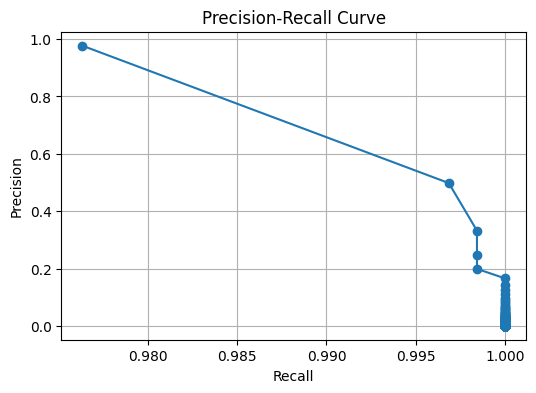

In [53]:
precision_recall_curve(bm25, query_df, ground_truth)

In [54]:
query = "kernel ridge regression"

query_terms = tokenize(query)

In [55]:
frq = np.array([[doc.get(term, 0) for doc in doc_term_counts] for term in query_terms])
n_qt = np.array([sum(term in doc for doc in doc_term_counts) for term in query_terms]).reshape(-1,1)

bm25 = BM25(invert_idx, k1=1.5, b=0.75)
scores = bm25.formula(query_terms)
df["score"] = df.index.map(scores).fillna(0)


In [56]:
from copy import deepcopy
sdf = deepcopy(df)

In [57]:
sdf = df.sort_values("score", ascending=False)
pd.set_option('display.max_colwidth', None)


In [58]:
print(sdf.loc[sdf["score"] > 0, ["title", "year", "score"]].head(10))


                                                                                                               title  \
176                                         Neural Tangent Kernel: Convergence and Generalization in Neural Networks   
553                                  Multiple Kernel Sparse Representations for Supervised and Unsupervised Learning   
415  Explainable Intelligent Fault Diagnosis for Nonlinear Dynamic Systems: From Unsupervised to Supervised Learning   
367                                           Nonparametric Transforms of Graph Kernels for Semi-Supervised Learning   
192                                                                                        Binarized Neural Networks   
145    Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1   
618                       Cluster Analysis: Unsupervised Learning via Supervised Learning with a Non-convex Penalty.   
614                   Joint Embedding Le

In [59]:
print(sdf.loc[sdf["score"] > 0, ["title", "year", "score"]].head(10))

                                                                                                               title  \
176                                         Neural Tangent Kernel: Convergence and Generalization in Neural Networks   
553                                  Multiple Kernel Sparse Representations for Supervised and Unsupervised Learning   
415  Explainable Intelligent Fault Diagnosis for Nonlinear Dynamic Systems: From Unsupervised to Supervised Learning   
367                                           Nonparametric Transforms of Graph Kernels for Semi-Supervised Learning   
192                                                                                        Binarized Neural Networks   
145    Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1   
618                       Cluster Analysis: Unsupervised Learning via Supervised Learning with a Non-convex Penalty.   
614                   Joint Embedding Le

In [60]:
print(sdf.loc[sdf["score"] > 0, ["title", "year", "score"]].shape[0]," documents found out of ", sdf.shape[0])

29  documents found out of  794


In [61]:
from rank_bm25 import BM25Okapi

In [62]:
# corpus must be tokenized
corpus = df["tokens"].tolist()

bm25_ref = BM25Okapi(corpus, k1=1.5, b=0.75)

query = query_terms
scores_ref = bm25_ref.get_scores(query)   # numpy array, size = N

In [63]:
df["scores_ref"] = scores_ref

In [64]:
df["score_ours"] = df.index.map(scores).fillna(0)

In [65]:
df = df.sort_values("scores_ref", ascending=False)
pd.set_option('display.max_colwidth', None)

In [66]:
print(df.loc[df["scores_ref"] > 0, ["title", "year", "scores_ref", "score_ours"]].head(10))


                                                                                                               title  \
176                                         Neural Tangent Kernel: Convergence and Generalization in Neural Networks   
553                                  Multiple Kernel Sparse Representations for Supervised and Unsupervised Learning   
415  Explainable Intelligent Fault Diagnosis for Nonlinear Dynamic Systems: From Unsupervised to Supervised Learning   
367                                           Nonparametric Transforms of Graph Kernels for Semi-Supervised Learning   
192                                                                                        Binarized Neural Networks   
145    Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1   
618                       Cluster Analysis: Unsupervised Learning via Supervised Learning with a Non-convex Penalty.   
614                   Joint Embedding Le